# Apartat A

In [1]:
import ast
import random

import pandas as pd
import numpy as np

from sklearn import linear_model, svm, datasets, neighbors, tree, naive_bayes
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, LeaveOneOut
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import scipy

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
df = pd.read_csv('pokemon.csv')

In [3]:
TARGET = 'is_legendary'
FILTER_RATE = 0.1
NAMES = df['name']

### APARTAT A

**EXPLORATORY DATA ANALYSIS**

Primer, solucionem algunes imperfeccions en les dades.

In [4]:
df.at[df['name'] == 'Minior', 'capture_rate'] = 70  # Because '30 (Meteorite)255 (Core)'
df['capture_rate'] = df['capture_rate'].astype('int64')

**Quants atributs té la vostra base de dades?**

In [5]:
len(df.columns)

41

**Quins tipus d'atributs tens?**

Categòrics, decimals i enters.

In [6]:
df.dtypes

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate           int64
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

**Com és el *target*, quantes categories diferents existeixen?**

El *target* és un atribut binari.

In [7]:
df[TARGET].unique()

array([0, 1])

**Podeu veure alguna correlació entre X i y?**

Hi ha atributs amb molta correlació amb el *target* i d'altres que no gaire.

In [8]:
df.corr()[TARGET].abs().sort_values(ascending=False)

is_legendary         1.000000
base_egg_steps       0.873488
base_total           0.485440
base_happiness       0.413108
sp_attack            0.406281
weight_kg            0.393023
experience_growth    0.361038
sp_defense           0.343241
capture_rate         0.328017
height_m             0.322155
speed                0.311639
hp                   0.308405
attack               0.303295
defense              0.265587
pokedex_number       0.196785
against_ghost        0.170746
generation           0.139029
against_dark         0.136315
against_psychic      0.106047
against_grass        0.070826
against_flying       0.062214
against_fight        0.059132
against_fairy        0.050165
percentage_male      0.045222
against_normal       0.034761
against_bug          0.027864
against_poison       0.024349
against_electric     0.023151
against_water        0.020679
against_rock         0.017588
against_dragon       0.014844
against_ground       0.012812
against_fire         0.011073
against_ic

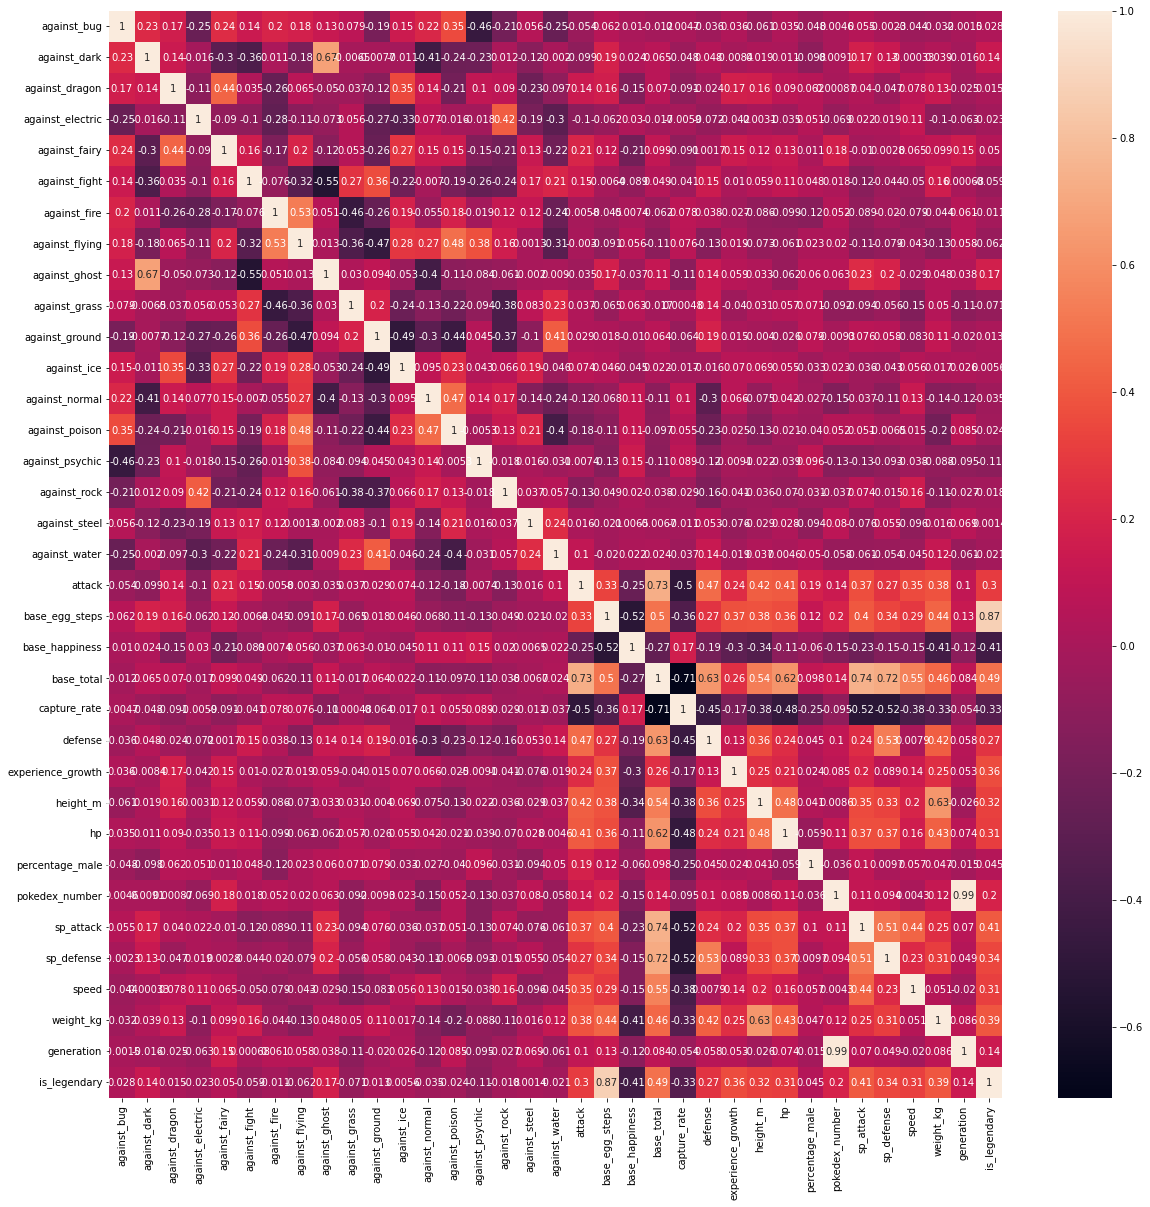

In [9]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(df.corr(), annot=True)

**Estan balancejades les etiquetes?**

Hi ha molts més *samples* de Pokemon comuns que de llegendaris.

In [10]:
df[TARGET].value_counts()

0    731
1     70
Name: is_legendary, dtype: int64

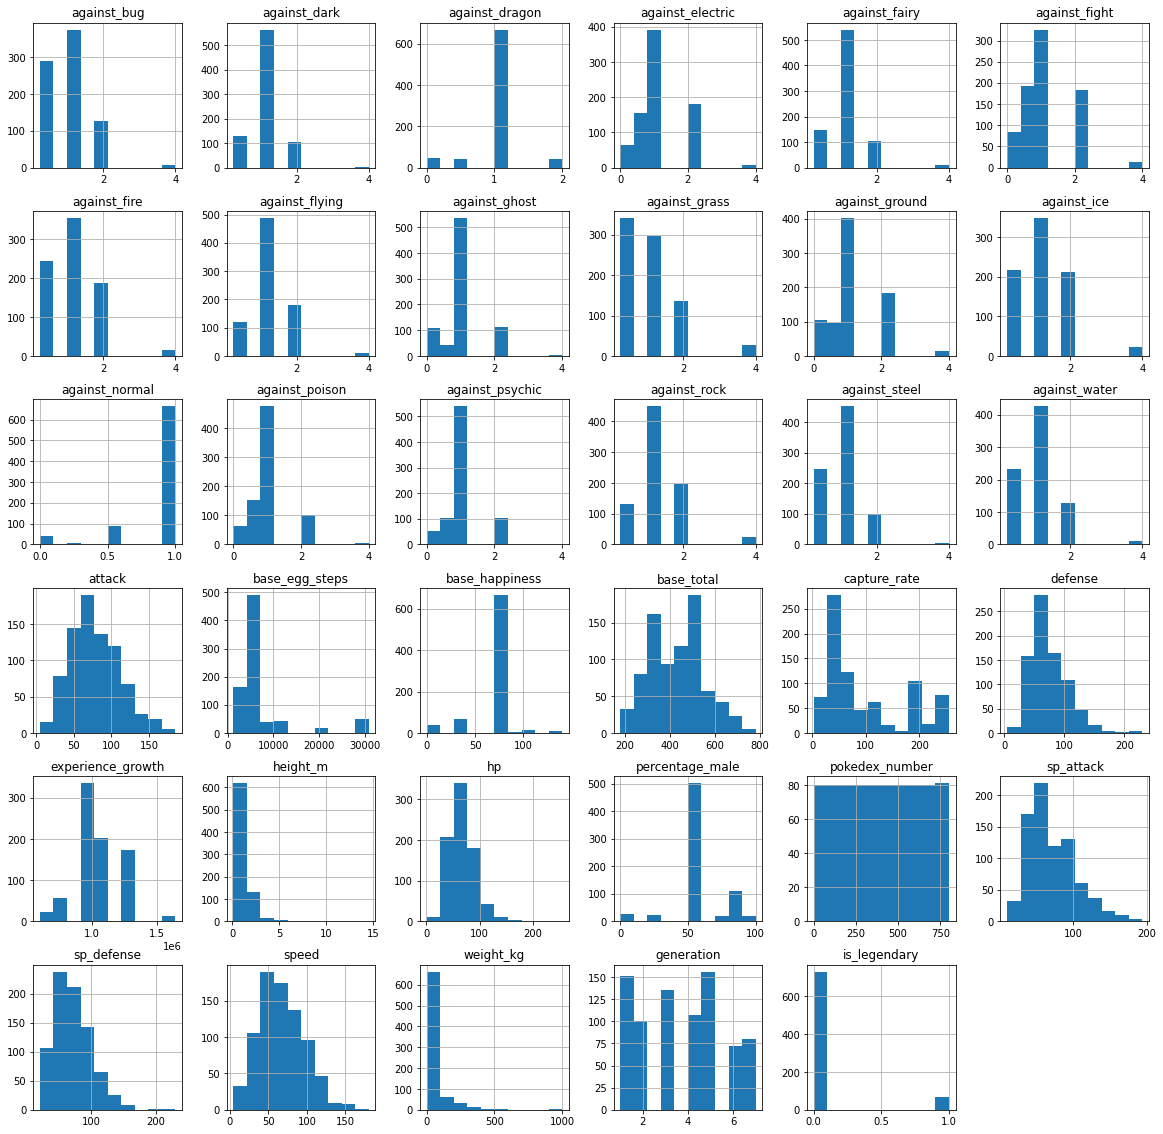

In [11]:
hist = df.hist(figsize=(20, 20))

**PREPROCESSING**

**Estan les dades normalitzades? Caldria fer-ho?**

Les dades no estan normalitzades. Caldria escalarles ja que els atributs numèrics tenen escales molt variades.

In [12]:
for col in df.select_dtypes(exclude='object'):
    _, pvalue = scipy.stats.normaltest(df[col])
    if pvalue > 1e-3:
        print(col)

**Com controleu les dades sense informació (NaNs)?**

Als atributs de tipus numèric, substituirem els valors NaN per la mitja de l'atribut. Els valors NaN dels atributs categòrics desapareixeran quan preprocessem les el *dataset*.

In [13]:
df.isnull().sum()[df.isnull().sum() > 0]

height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64

In [14]:
df.fillna(df.mean(), inplace=True)

**Com codifiqueu les dades categòriques? (OrdinalEncoder, OneHotEncoder)**

Usem la funció `get_dummies` de la llibreria `pandas` que converteix les variables categòriques en variables *dummy*.

In [15]:
df['abilities'] = df['abilities'].apply(ast.literal_eval)
df[df['abilities'].explode().unique()] = 0

for idx, row in df.iterrows():
    for cat in row['abilities']:
        df.at[idx, cat] = 1

df.drop(columns='abilities', inplace=True)
df = pd.get_dummies(df, columns=['classfication', 'type1', 'type2'], prefix=['', '1', '2'], prefix_sep='')
df.drop(columns=['name', 'japanese_name'], inplace=True)

**Quin tipus de normalització serà més adient per les vostres dades?**

Escalarem les dades per que estiguien en l'interval $[0, 1]$.

In [16]:
df = pd.DataFrame(
    MinMaxScaler().fit_transform(df),
    columns=df.columns
)
df.head()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,2ghost,2grass,2ground,2ice,2normal,2poison,2psychic,2rock,2steel,2water
0,0.200000,0.2,0.5,0.125,0.066667,0.125,0.466667,0.466667,0.25,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.200000,0.2,0.5,0.125,0.066667,0.125,0.466667,0.466667,0.25,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.200000,0.2,0.5,0.125,0.066667,0.125,0.466667,0.466667,0.25,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.066667,0.2,0.5,0.250,0.066667,0.250,0.066667,0.200000,0.25,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.066667,0.2,0.5,0.250,0.066667,0.250,0.066667,0.200000,0.25,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Després de fer el `get_dummies()` ens queda un *dataset* amb massa columnes. Ens quedem amb les que tenen una correlació major que la variable global `FILTER_RATE`.

In [17]:
corr = df.corr().abs()[TARGET].sort_values(ascending=False)
corr = corr[corr > FILTER_RATE]
df = df[corr.index]  # dataset filtered by correlation
corr


is_legendary         1.000000
base_egg_steps       0.873488
base_total           0.485440
base_happiness       0.413108
sp_attack            0.406281
                       ...   
Grassland Pokémon    0.114252
1dragon              0.113667
against_psychic      0.106047
1steel               0.101196
Clear Body           0.100196
Name: is_legendary, Length: 105, dtype: float64

**Caldra aplicar un PCA?**

No cal aplicar un PCA perquè la majoria dels nostres atributs són categórics.

**Es poden aplicar `PolynomialFeatures` per millorar la classificació?**

No perquè hi ha massa atributs. Els `PolynomialFeatures` aumenten la mida del *dataset* de manera exponencial.

Creem dos *datasets*. Un amb la mateixa quantitat de *pokemons* communs que llegendaris (`df_balanced`) i l'altre l'original (`df_imbalanced`).

In [18]:
df_imbalanced = df.copy(deep=True)
idx_common = random.sample(list(df[df[TARGET] == 0].index), 731-70)
df_balanced = df.drop(index=idx_common)
df_balanced.reset_index(inplace=True, drop=True)

dfs = [df_imbalanced, df_balanced]

**MODEL SELECTION**

**Quins models heu considerat?**

In [19]:
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'SVC': svm.SVC(kernel='linear', C=1.0),
    'LinearSVC': svm.LinearSVC(C=1.0, max_iter=1000000),
    'SVCrbf': svm.SVC(kernel='rbf', gamma=0.7, C=1.0),
    'SVCpoly': svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.0),
    'SGDClassifier': linear_model.SGDClassifier(loss="modified_huber", alpha=0.1),
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_neighbors=15),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'GaussianNB': naive_bayes.GaussianNB()
}

In [20]:
scores_ls = []
confusion_matrix_ls = []

for dataframe in dfs:
    X = dataframe.drop(columns=TARGET)
    y = dataframe[TARGET]

    scores = {name: [] for name in classifiers}
    cms = {name: [] for name in classifiers}
    for it in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        for name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            score = clf.score(X_test, y_test)
            scores[name].append(score)

            if it == 1:
                cm = confusion_matrix(y_test, y_pred)
                cms[name] = cm.ravel()
                # disp = ConfusionMatrixDisplay(
                #     confusion_matrix=cm,
                #     display_labels=classifier.classes_
                # )
                # disp.plot()
                # plt.title(f'Matriu de confusió amb el classificador {name}')
                # plt.show()

    
    scores = {name: sum(score)/len(score) for name, score in scores.items()}
    scores_ls.append(scores)
    confusion_matrix_ls.append(cms)

pd.DataFrame(scores_ls, index=['imbalanced', 'balanced']).transpose()

,imbalanced,balanced
LogisticRegression,0.981366,0.985714
SVC,0.992547,0.992857
LinearSVC,0.993789,0.992857
SVCrbf,0.996273,0.985714
SVCpoly,0.911801,0.478571
SGDClassifier,0.956522,0.992857
KNeighborsClassifier,0.916770,0.678571
DecisionTreeClassifier,0.995031,0.942857
GaussianNB,0.926708,0.664286


In [21]:
confusion_matrix_ls

[{'LogisticRegression': array([143,   0,   5,  13]),
  'SVC': array([143,   0,   0,  18]),
  'LinearSVC': array([143,   0,   0,  18]),
  'SVCrbf': array([143,   0,   0,  18]),
  'SVCpoly': array([143,   0,  18,   0]),
  'SGDClassifier': array([143,   0,   7,  11]),
  'KNeighborsClassifier': array([143,   0,  18,   0]),
  'DecisionTreeClassifier': array([143,   0,   0,  18]),
  'GaussianNB': array([143,   0,  16,   2])},
 {'LogisticRegression': array([14,  1,  1, 12]),
  'SVC': array([15,  0,  1, 12]),
  'LinearSVC': array([15,  0,  1, 12]),
  'SVCrbf': array([14,  1,  0, 13]),
  'SVCpoly': array([ 0, 15,  0, 13]),
  'SGDClassifier': array([15,  0,  1, 12]),
  'KNeighborsClassifier': array([15,  0,  7,  6]),
  'DecisionTreeClassifier': array([14,  1,  0, 13]),
  'GaussianNB': array([15,  0, 11,  2])}]

**Considereu les SVM amb els diferents *kernels* implementats.**

Hem considerat *kernel* lineal, polinòmic i funció de base radial (rbf).

**Quin creieu que serà el més precís?**

**Quin serà el més ràpid?**

El model més ràpid

**Seria una bona idea fer un `ensemble`? Quins inconvenients creieu que pot haver-hi?**

Provem alguns classificadors d'`ensemble` amb el `df_imbalanced`.

In [22]:
X = df_imbalanced.drop(columns=TARGET)
y = df_imbalanced[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print(f'{rf.__class__.__name__}: {score}')

RandomForestClassifier: 0.9937888198757764


In [24]:
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
bagging.fit(X_train,y_train)
y_pred = bagging.predict(X_test)
score = bagging.score(X_test, y_test)
print(f'{bagging.__class__.__name__}: {score}')

BaggingClassifier: 0.968944099378882


In [25]:
boosting = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=1.0,
    max_depth=1,
    random_state=0
)
boosting.fit(X_train, y_train)
score = boosting.score(X_test, y_test)
print(f'{boosting.__class__.__name__}: {score}')

GradientBoostingClassifier: 0.9937888198757764


**CROSSVALIDATION**

**Per què és important cross-validar els resultats?**

Per evitar que una partició concreta del *dataset* aporti un *bias* a les mètriques de validació.

**Separa la base de dades en el conjunt de train-test. Com de fiables serán els resultats obtinguts? En quins casos serà més fiable, si tenim moltes dades d'entrenament o poques?**

Serà més fiable quan tinguem moltes dades d'entrenament.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn

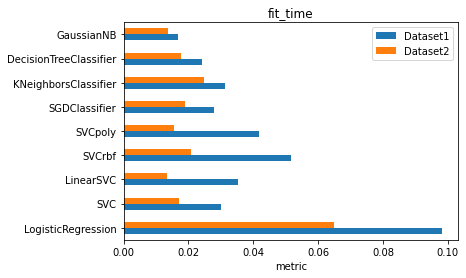

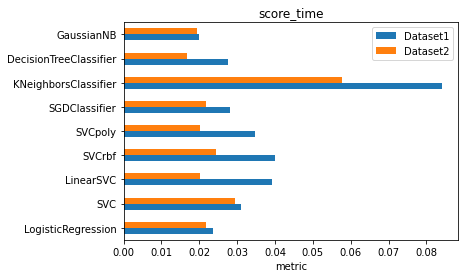

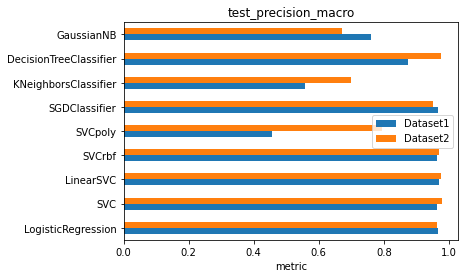

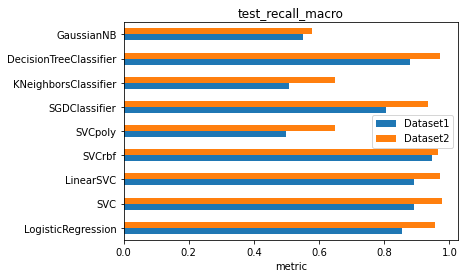

In [27]:
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'SVC': svm.SVC(kernel='linear', C=1.0),
    'LinearSVC': svm.LinearSVC(C=1.0, max_iter=1000000),
    'SVCrbf': svm.SVC(kernel='rbf', gamma=0.7, C=1.0),
    'SVCpoly': svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.0),
    'SGDClassifier': linear_model.SGDClassifier(loss="modified_huber", alpha=0.1),
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_neighbors=15),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'GaussianNB': naive_bayes.GaussianNB()
}

scoring = ['precision_macro', 'recall_macro']
metrics = ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']
data = []

for dataframe in dfs:
    X = dataframe.drop(columns=TARGET)
    y = dataframe[TARGET]
    scores = []
    for name, clf in classifiers.items():
        cv = cross_validate(clf, X, y, scoring=scoring, cv=5)
        cv = [ls.mean() for metric, ls in cv.items()]
        scores.append(cv)
    data.append(scores)

data = np.array(data)
for i, metric in enumerate(metrics):
    pd.DataFrame(
        np.array([data[0, :, i], data[1, :, i]]).transpose(),
        columns=['Dataset1', 'Dataset2'],
        index=classifiers.keys()
    ).plot.barh()
    plt.title(metric)
    plt.xlabel('metric')

**Quin tipus de K-fold heu escollit? Quants conjunts heu seleccionat (quina k)? Com afecta els diferents valors de k?**

Utilitzant el Stratified method. Els plecs es fan conservant el percentatge de mostres per a cada classe. Els valors de la k faràn que canvi el número de plecs que es fa en el nostre dataset. Com que no tenim tantes dades hem de posar un número petit per tal de que no falli. Hem escollit un valor de k: 5.

**Es viable o convenient aplicar LeaveOneOut?**

Si es fa servir una unica observació per calcular el error, aquest variarar molt segons quina observació es fagi servir. Per evitar-ho, el procés s'ha de repetir tants cops com observacions tenim i a cada iteració deixem fora una iteració diferent, ajustant el model amb la resta i calculant l'error. Al final farem la mitja de tots els errors. Aquest procés permet reduir la variabilitat quan dividim aleatoriament les observacions en dos grups. Per tant, els resultats obtinguts en principi seran més exactes però té un cost computacional molt més alt.

In [28]:
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'SVC': svm.SVC(kernel='linear', C=1.0),
    'LinearSVC': svm.LinearSVC(C=1.0, max_iter=1000000),
    'SVCrbf': svm.SVC(kernel='rbf', gamma=0.7, C=1.0),
    'SGDClassifier': linear_model.SGDClassifier(loss="modified_huber", alpha=0.1),
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_neighbors=15),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'GaussianNB': naive_bayes.GaussianNB()
}

loo = LeaveOneOut()
scores_ls = []

for dataframe in dfs:
    X = dataframe.drop(columns=TARGET)
    y = dataframe[TARGET]
    scores = {name: [] for name in classifiers}
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        for name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            scores[name].append(score)
    scores = {name: sum(score)/len(score) for name, score in scores.items()}    
    scores_ls.append(scores)

pd.DataFrame(scores_ls, index=['imbalanced', 'balanced']).transpose()

,imbalanced,balanced
LogisticRegression,0.986267,0.978571
SVC,0.992509,0.985714
LinearSVC,0.991261,0.985714
SVCrbf,0.990012,0.985714
SGDClassifier,0.963795,0.971429
KNeighborsClassifier,0.920100,0.692857
DecisionTreeClassifier,0.996255,0.957143
GaussianNB,0.932584,0.642857


**METRIC ANALYSIS**

**A teoria, hem vist el resultat d'aplicar el `accuracy_score` sobre dades no balancejades. Podrieu explicar i justificar quina de les següents mètriques será la més adient pel vostre problema? `accuracy_score`, `f1_score` o `average_precision_score`.**

Hauriem d'utilitzar el `average_precision_score`degut a que el nostre atribut objectiu és binari (La nostra classificació és binària). Els altres dos s'utilitzen en els casos en que ens trobem amb multiclasses.

**Mostreu la Precisió-Recall Curve i la ROC Curve. Quina és més rellevant pel vostre dataset? Expliqueu amb les vostres paraules, la diferencia entre una i altre**

Pel nostre dataset seria més interessant utilitzar el Precisió-Recall Curve degut a que tenim molt poc balancejades les dades del nostre atribut objectiu. Tot i així, com que tenim un dataset modificat equilibrat podem fer servir el ROC Curve.

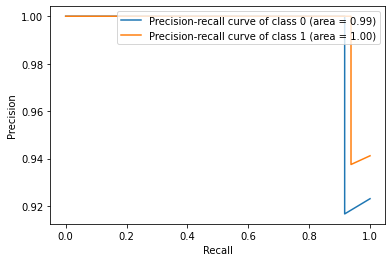

In [33]:
X = df_balanced.drop(columns=TARGET)
y = df_balanced[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svc = svm.SVC(kernel='rbf', gamma=0.7, probability=True)
svc.fit(X_train, y_train)
probs = svc.predict_proba(X_test)

# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}

plt.figure()
for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, probs[:, i])
    average_precision[i] = average_precision_score(y_test == i, probs[:, i])

    plt.plot(
        recall[i],
        precision[i],
        label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i])
    )
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="upper right")    

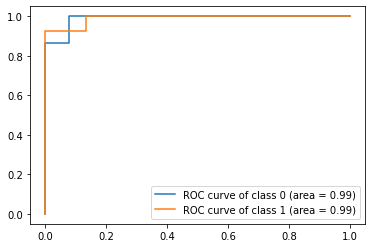

In [37]:
# Compute ROC curve and ROC area for each class
X = df_balanced.drop(columns=TARGET)
y = df_balanced[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svc = svm.SVC(C=10.0, kernel='linear', gamma=0.9, probability=True)
svc.fit(X_train, y_train)
probs = svc.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

**Què mostra la funció `classification_report()`? Quina métrica us fixareu per tal de optimitzar-ne la classificació pel vostre cas?**

In [38]:
X = df_imbalanced.drop(columns=TARGET)
y = df_imbalanced[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_report = classification_report(
    y_test,
    y_pred,
    labels=[0, 1],
    target_names=['common', 'legendary'],
    output_dict=True
)

pd.DataFrame(clf_report).drop(columns='accuracy')

,common,legendary,macro avg,weighted avg
precision,0.965517,0.875000,0.920259,0.954835
recall,0.985915,0.736842,0.861379,0.956522
f1-score,0.975610,0.800000,0.887805,0.954886
support,142.000000,19.000000,161.000000,161.000000


**HYPERPARAMETER SEARCH**

In [39]:
X = df_imbalanced.drop(columns=TARGET)
y = df_imbalanced[TARGET]

**Quines formes de buscar el millor parametre heu trobat? Són costoses computacionalment parlant?**

GridSearchCV —> mirar totes les combinacions de paramatres possibles

RandomizedSerachCV —> mostreja nombre determinat de candidats d'un espai de parametres amb una distr especificada

Si que son costoses computacionalment, el GridSearch molt més

**Si disposem de recursos limitats (per exemple, un PC durant 1 hora) quin dels dos métodes creieu que obtindrà millor resultat final?**

Donaria millor resultats el `RandomizedSearchCV` ja que és molt més ràpid que no pas l'altre que proba totes les combinacions possibles.

**Existeixen altres mètodes de búsqueda més eficients?**

Some models can fit data for a range of values of some parameter almost as efficiently as fitting the estimator for a single value of the parameter. This feature can be leveraged to perform a more efficient cross-validation used for model selection of this parameter.

The most common parameter amenable to this strategy is the parameter encoding the strength of the regularizer. In this case we say that we compute the regularization path of the estimator.

**Feu la prova, i amb el model i el metode de crossvalidació escollit, configureu els diferents metodes de búsqueda per a que s'executin durant el mateix temps (i.e. depenent del problema, 0,5h-1 hora). Analitzeu quin ha arribat a una millor solució. (estimeu el temps que trigarà a fer 1 training, i aixi trobeu el número de intents que podeu fer en cada cas.)**

In [44]:
parameters = {
    'kernel':('linear', 'poly', 'rbf'),
    'gamma': np.linspace(0, 1, 10),
    'C': np.linspace(0.01, 3, 10)
}

In [45]:
clf = GridSearchCV(svm.SVC(), parameters)
clf.fit(X, y)

print(clf.best_params_)
print(f"Tarda {clf.cv_results_['mean_fit_time'].mean()} per training")

{'C': 0.34222222222222226, 'gamma': 0.3333333333333333, 'kernel': 'rbf'}
Tarda 0.02965017414093018 per training


In [47]:
clf = RandomizedSearchCV(svm.SVC(), parameters, random_state=0, n_iter=100)
clf.fit(X, y)
print(clf.best_params_)
print(f"Tarda {clf.cv_results_['mean_fit_time'].mean()} per training")

{'kernel': 'rbf', 'gamma': 0.4444444444444444, 'C': 0.6744444444444445}
Tarda 0.028851700305938713 per training


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c3c3f0e5-53b5-41aa-b55f-8ff8474beec2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>